# Customer Personality Clustering in R
### In this analysis, I attempted to distinguish distinct, homogenous groups of customers with the use of Principal Component Analysis and K-Means Clustering. It can help with better understanding of specific customer segments, allow for more personalized approach and facilitate further data exploration and analysis. All of this was done on publicly available dataset downloaded from Kaggle. 

In [257]:
options(warn=-1)
suppressMessages(library(tidyverse))
suppressMessages(library(corrplot))
suppressMessages(library(factoextra))
library(ggbiplot)

## Data import and preparation
After importing and inspecting data, all the missing values were excluded. Afterwards, all the variables allowing further dimensionality reduction were selected. Their distributions were plotted in form of boxplots in order to depict all of the outliers, for which appropriate filters were set to exclude them.

In [258]:
data <- read.delim("~/Desktop/marketing_campaign.csv")

glimpse(data)
cat('\nNumber of rows with missing values:', sum(is.na(data)))

Rows: 2,240
Columns: 29
$ ID                  <int> 5524, 2174, 4141, 6182, 5324, 7446, 965, 6177, 485…
$ Year_Birth          <int> 1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 19…
$ Education           <chr> "Graduation", "Graduation", "Graduation", "Graduat…
$ Marital_Status      <chr> "Single", "Single", "Together", "Together", "Marri…
$ Income              <int> 58138, 46344, 71613, 26646, 58293, 62513, 55635, 3…
$ Kidhome             <int> 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,…
$ Teenhome            <int> 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,…
$ Dt_Customer         <chr> "04-09-2012", "08-03-2014", "21-08-2013", "10-02-2…
$ Recency             <int> 58, 38, 26, 26, 94, 16, 34, 32, 19, 68, 11, 59, 82…
$ MntWines            <int> 635, 11, 426, 11, 173, 520, 235, 76, 14, 28, 5, 6,…
$ MntFruits           <int> 88, 1, 49, 4, 43, 42, 65, 10, 0, 0, 5, 16, 61, 2, …
$ MntMeatProducts     <int> 546, 6, 127, 20, 118, 98, 164, 56, 24, 6, 6, 11, 4…
$ MntFishProduct


Number of observations before removal: 2240
Number of observations after removal: 2139

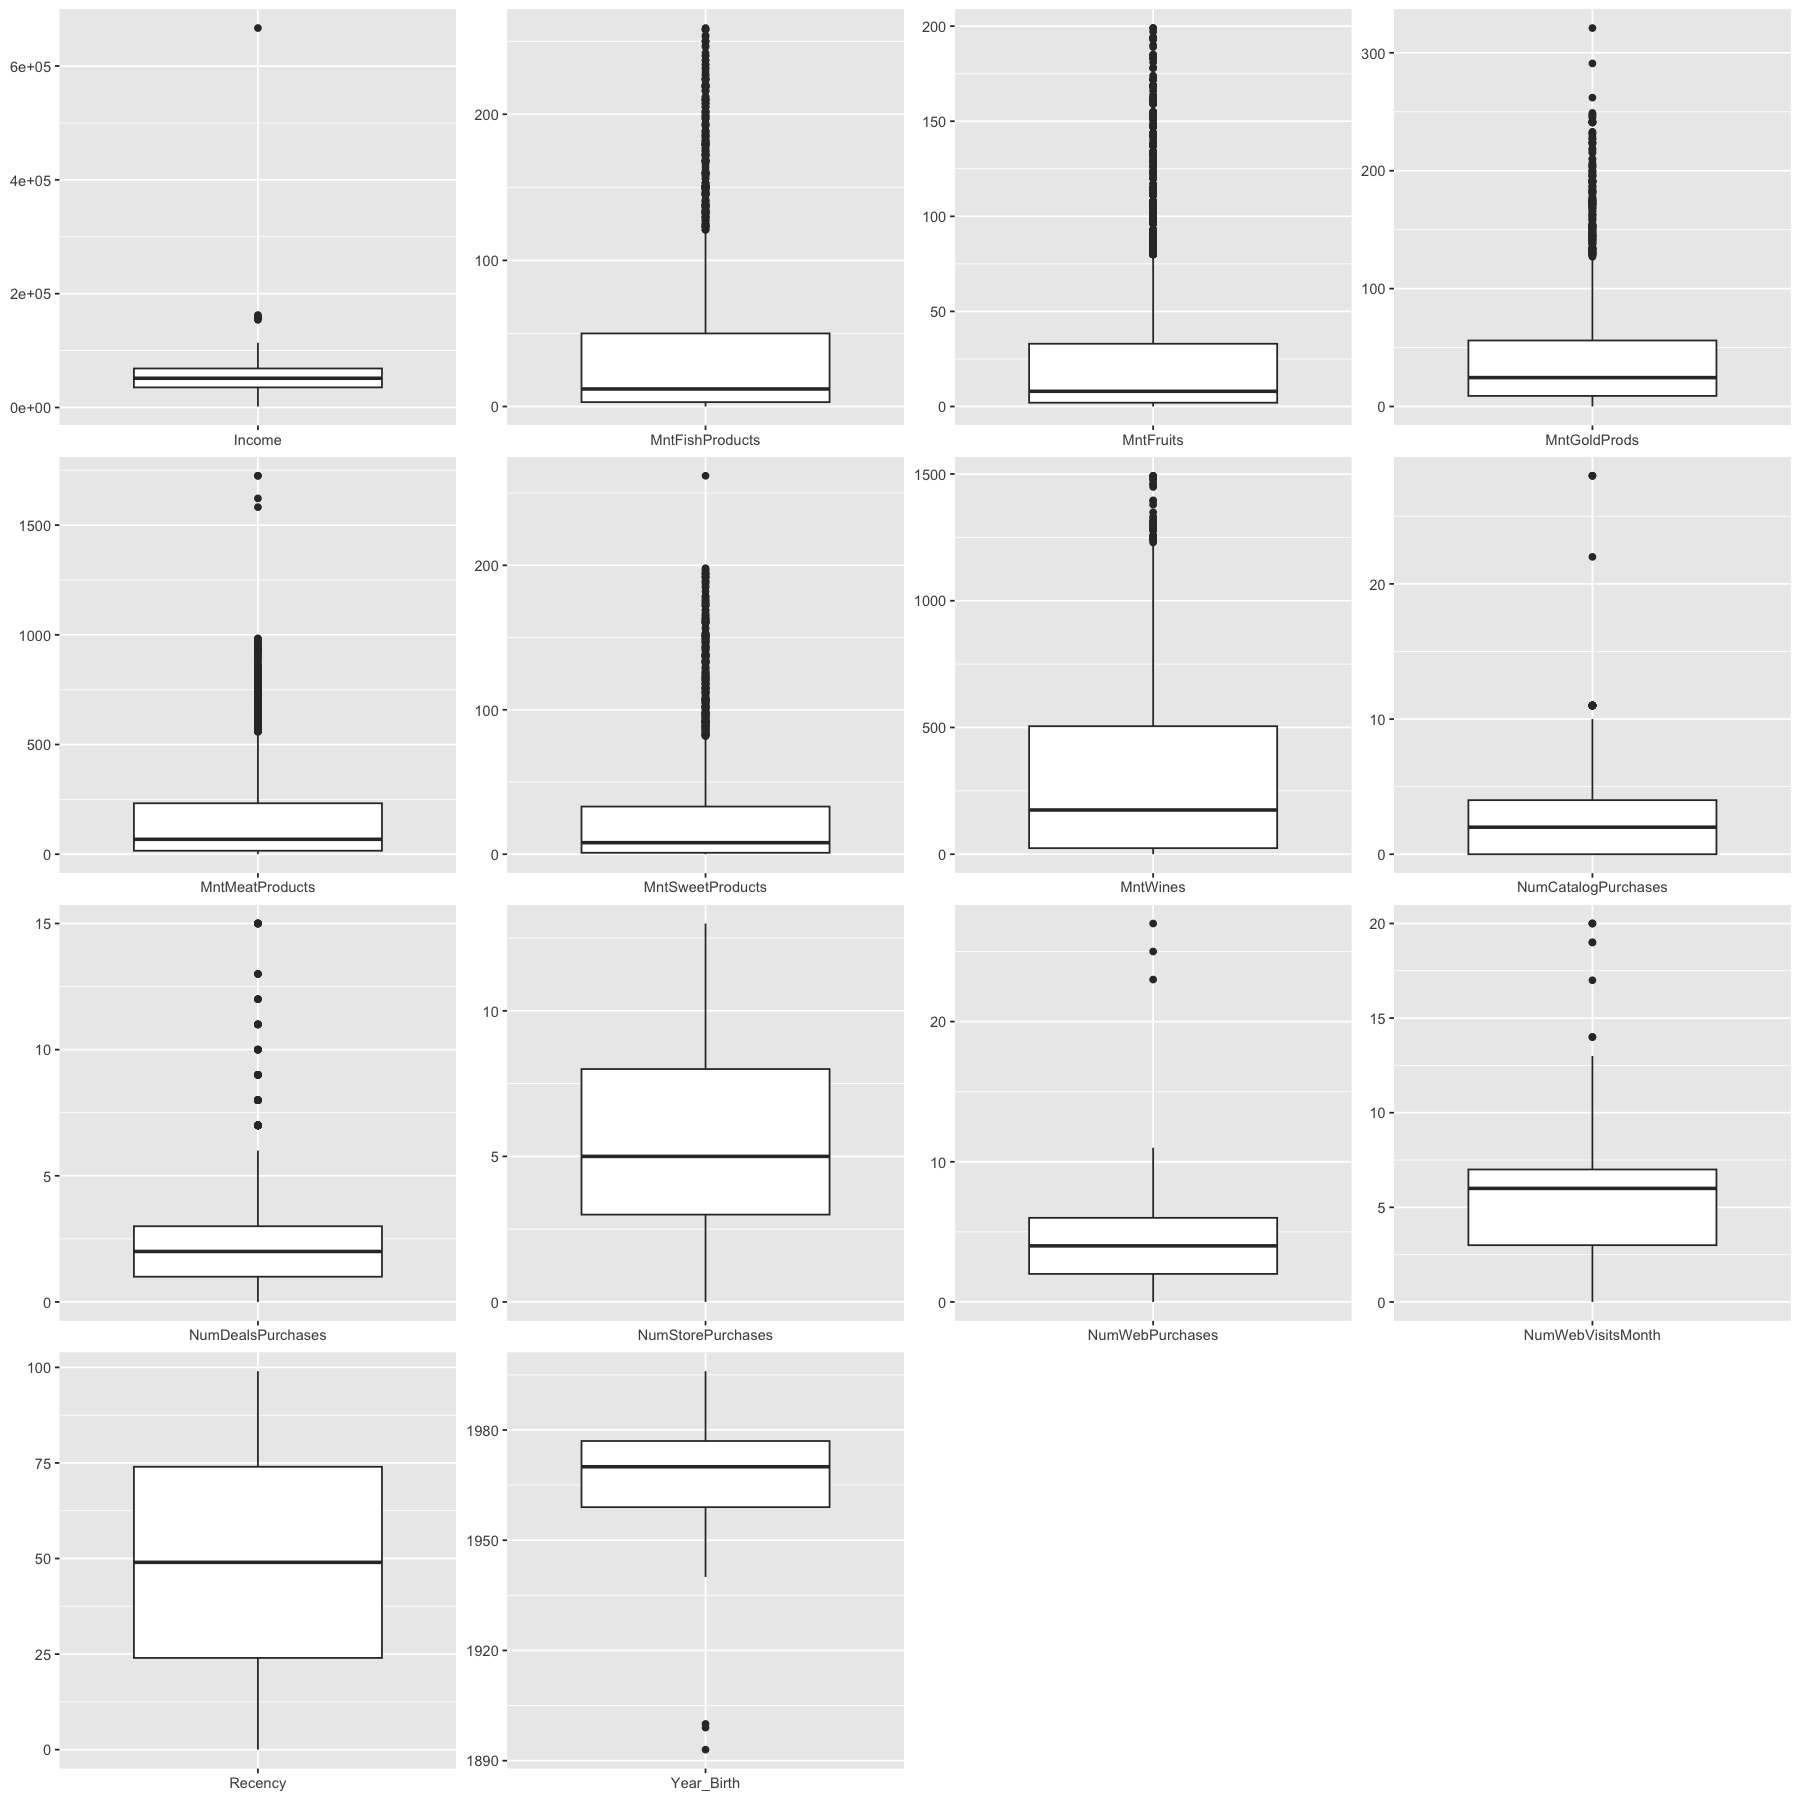

In [259]:
cat('\nNumber of observations before removal:', nrow(data))

data <- data[complete.cases(data), ]

data[ ,-c(1,3,4,6,7,8,21,22,23,24,25,26,27,28,29)] %>% 
    pivot_longer(cols=everything()) %>%
    ggplot(aes(name, value)) +
    facet_wrap(~name, scales="free") +
    geom_boxplot() +
    theme(strip.text.x=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank())

data <- filter(data,
               Income < 200000 &
               MntMeatProducts < 1500 &
               MntSweetProducts < 200 &
               NumCatalogPurchases < 10 &
               NumWebPurchases < 20 &
               Year_Birth > 1920)

cat('\nNumber of observations after removal:', nrow(data))

## Multicollinearity check
Creation of correlation matrix to identify data redundancy. Many medium/highly correlated variables makes PCA really valuable tool in this case as it will not only reduce dimensionality of data for further clustering, but also combine those highly correlated variables into a set of uncorrelated ones.

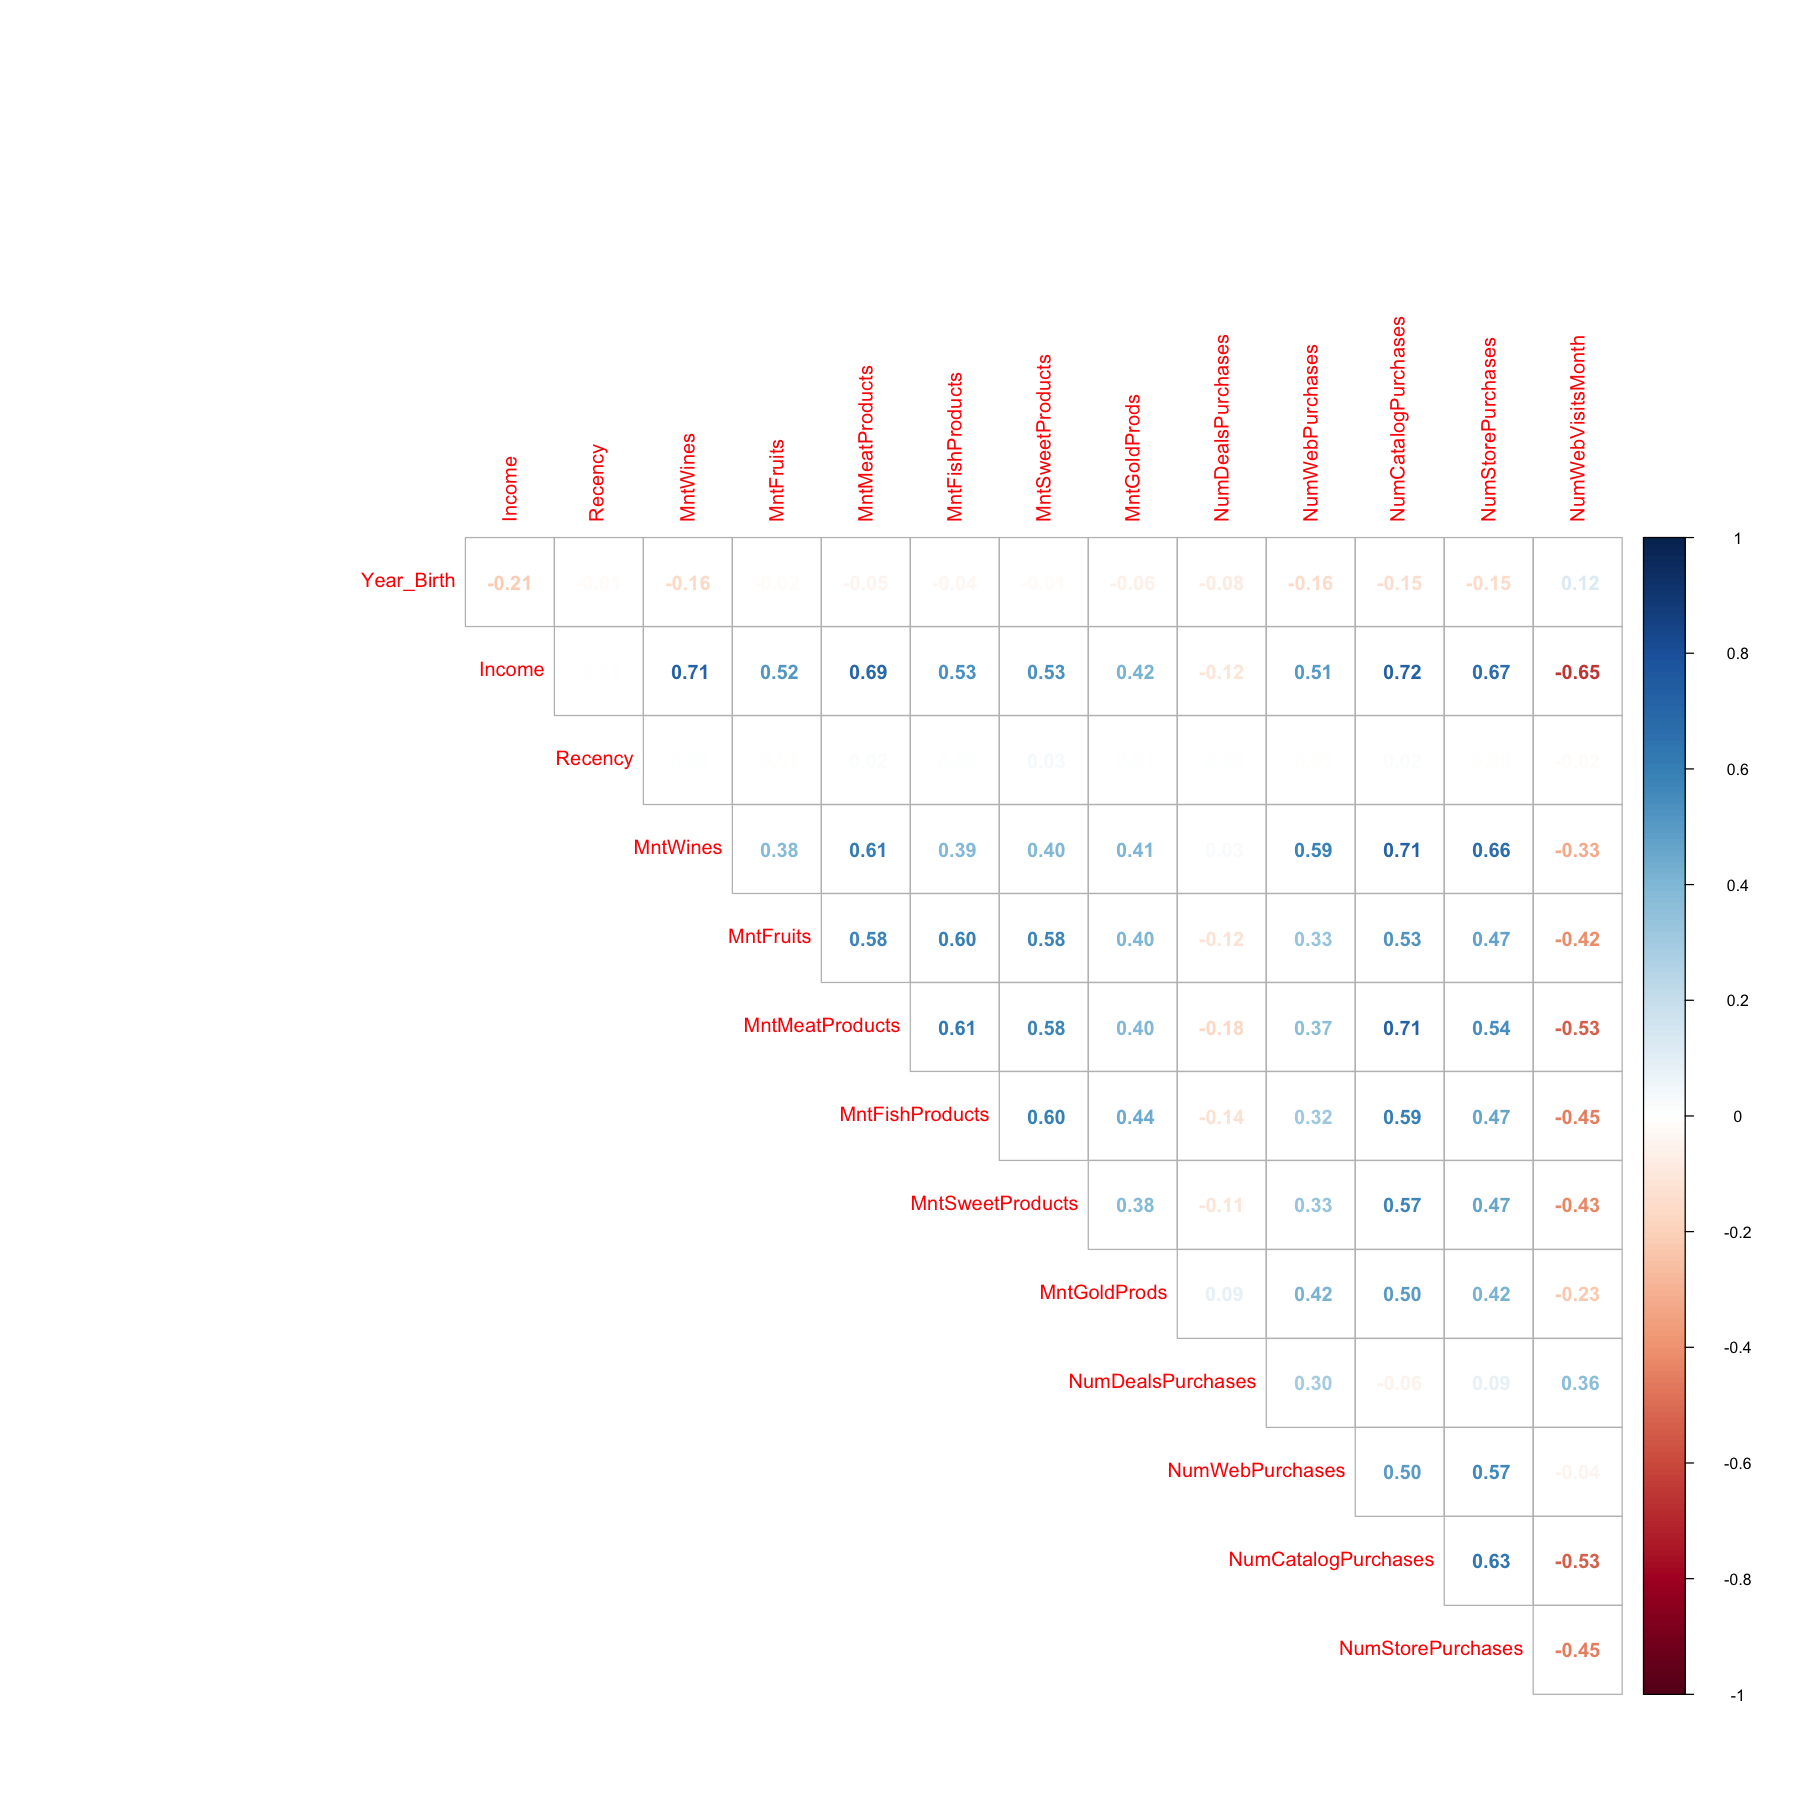

In [253]:
pca_data <- data[ ,-c(1,3,4,6,7,8,21,22,23,24,25,26,27,28,29)]

options(repr.plot.width=15, repr.plot.height=15)
corrplot(cor(pca_data), type='upper', method='number', diag=F)

## Principal Component Analysis
After standardization of all the variables, PCA was performed. Scree plot visualizes importance of individual principal components in describing data variability. By convention, as eigenvalues which are less than 1 indicate that PC account for less variance in data than a single variable on average, this parameter will be set as a threshold for PCs retention in this analysis as well. Therefore, only four principal components will be taken into account for further clustering.

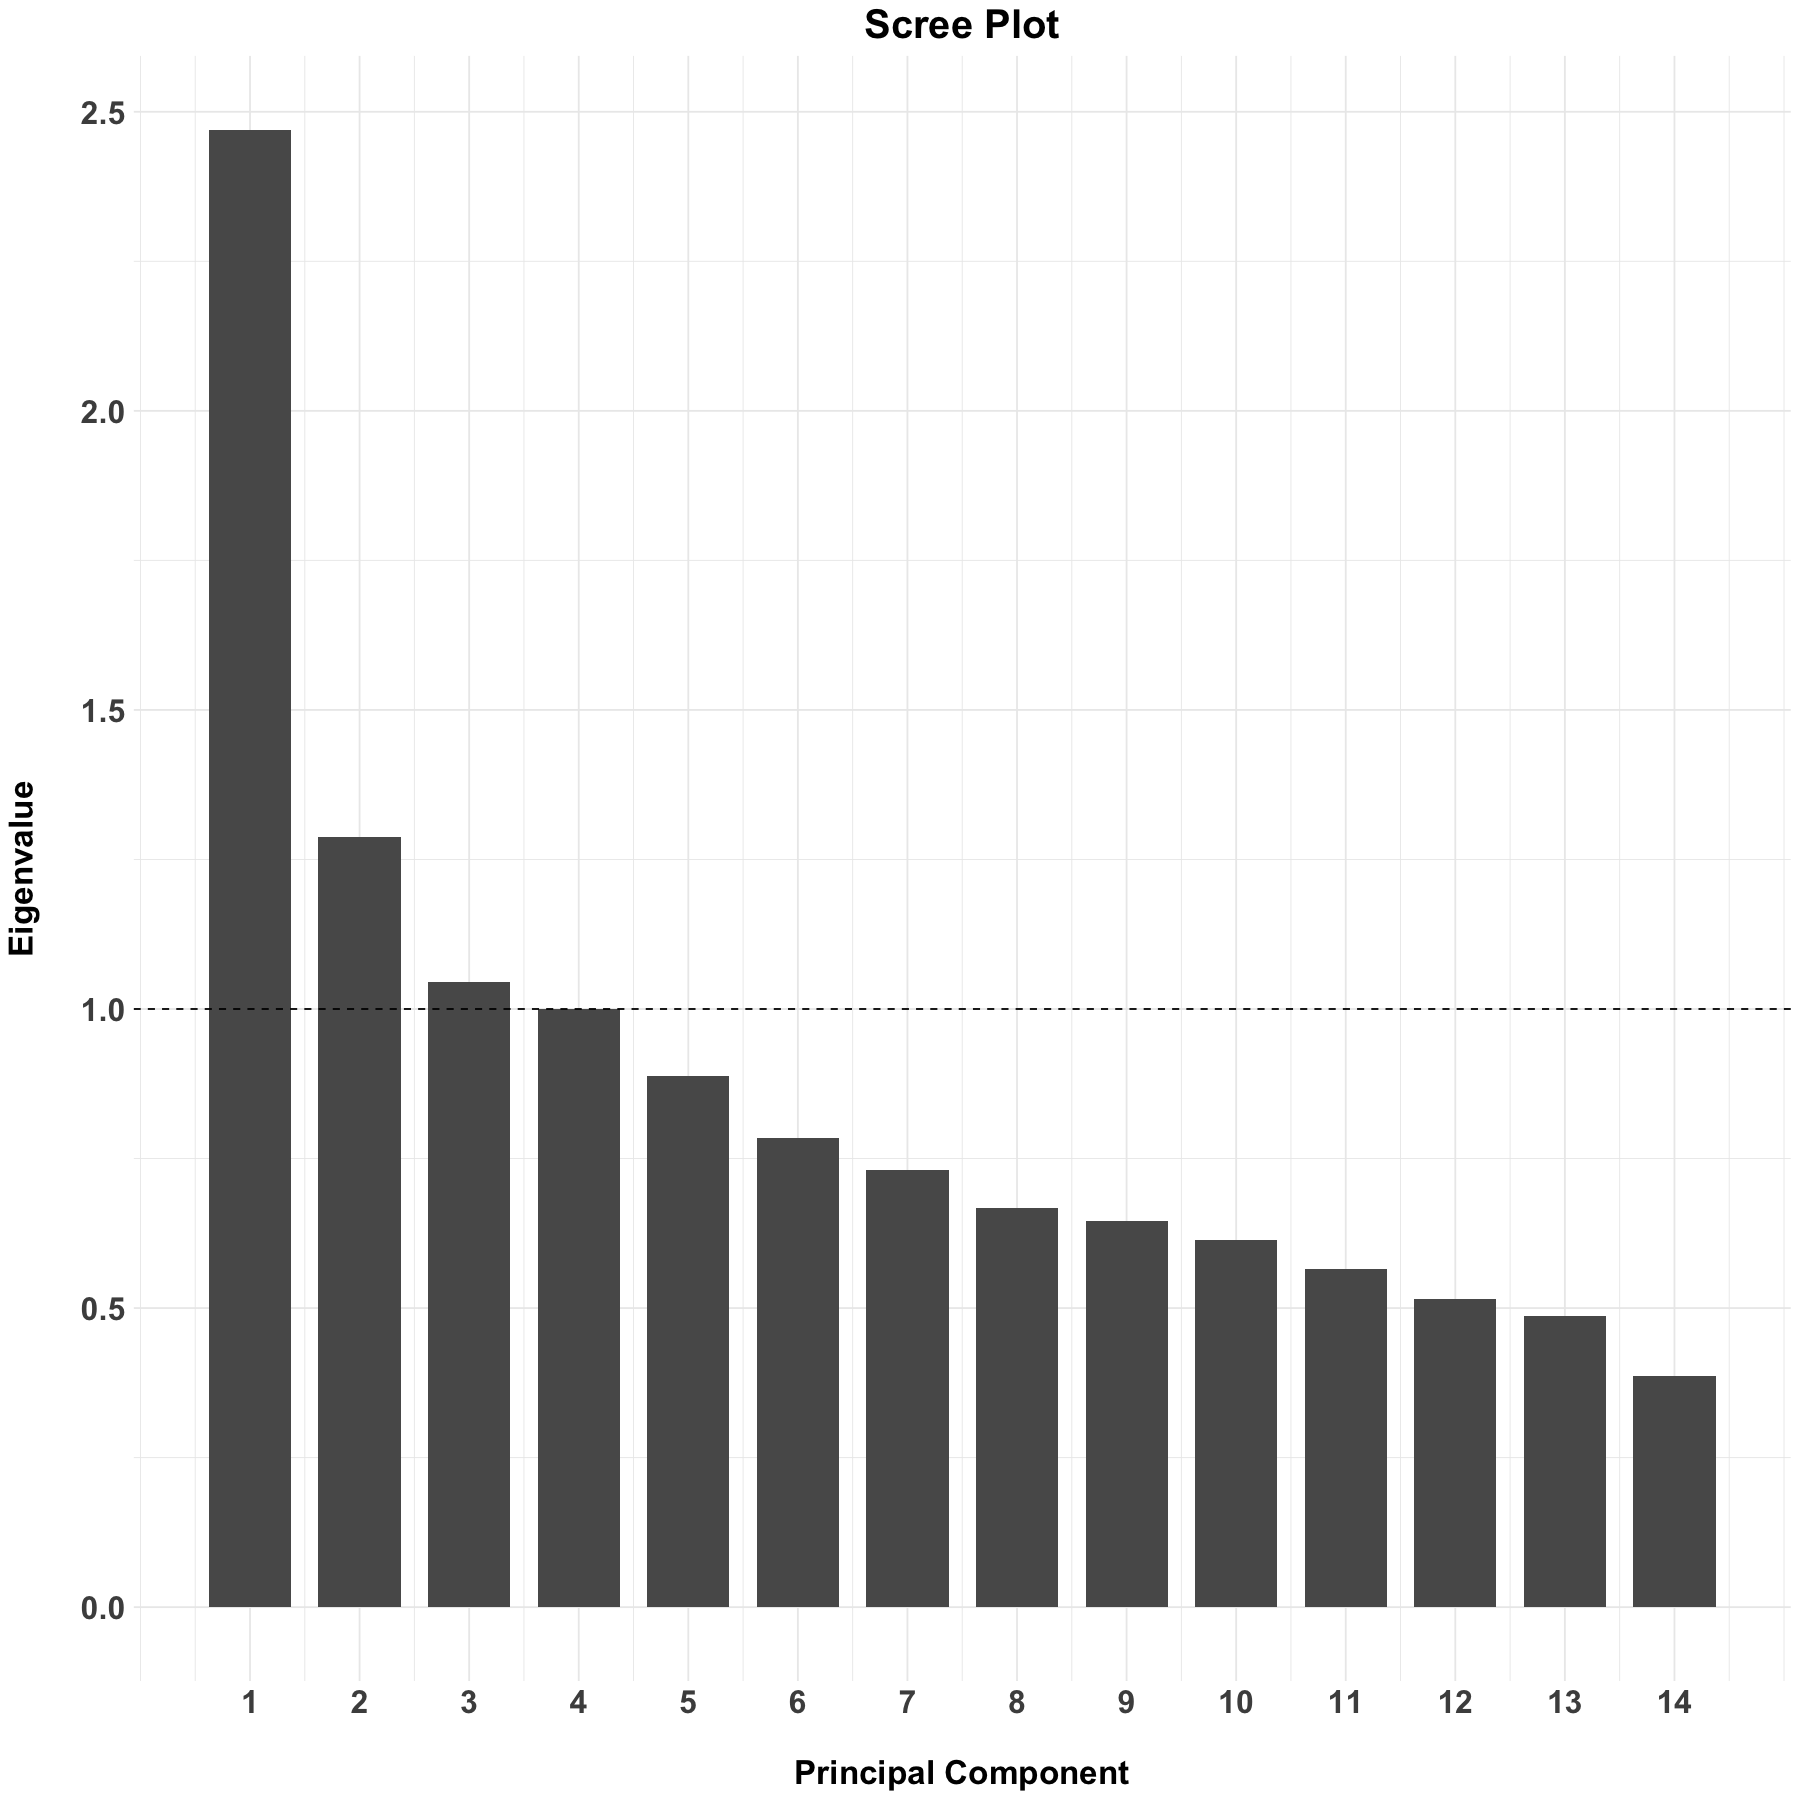

In [254]:
pca <- prcomp(pca_data, center=T, scale=T)
ggplot() +
    geom_col(aes(x=1:length(pca$sdev), y=pca$sdev), width=0.75) +
    geom_hline(yintercept=1, linetype=2) +
    labs(x='\nPrincipal Component', y='Eigenvalue\n', title='Scree Plot') +
    theme_minimal() +
    scale_x_continuous(breaks=1:14) +
    theme(axis.title.x=element_text(size=20, face='bold'),
          text=element_text(size=24, face='bold'),
          axis.title.y=element_text(size=20, face='bold'),
          plot.title=element_text(hjust=0.5, face='bold', size=24))

## K-Means clustering
Elbow plot visualizes trade-off between number of groups which can be created with the use of clustering algorithm and the modeling optimization gained by creating these groups. As process of optimal number of clusters selection is to some point subjective, in this case 3 clusters were chosen - a place of most visible 'elbow' of a curve.

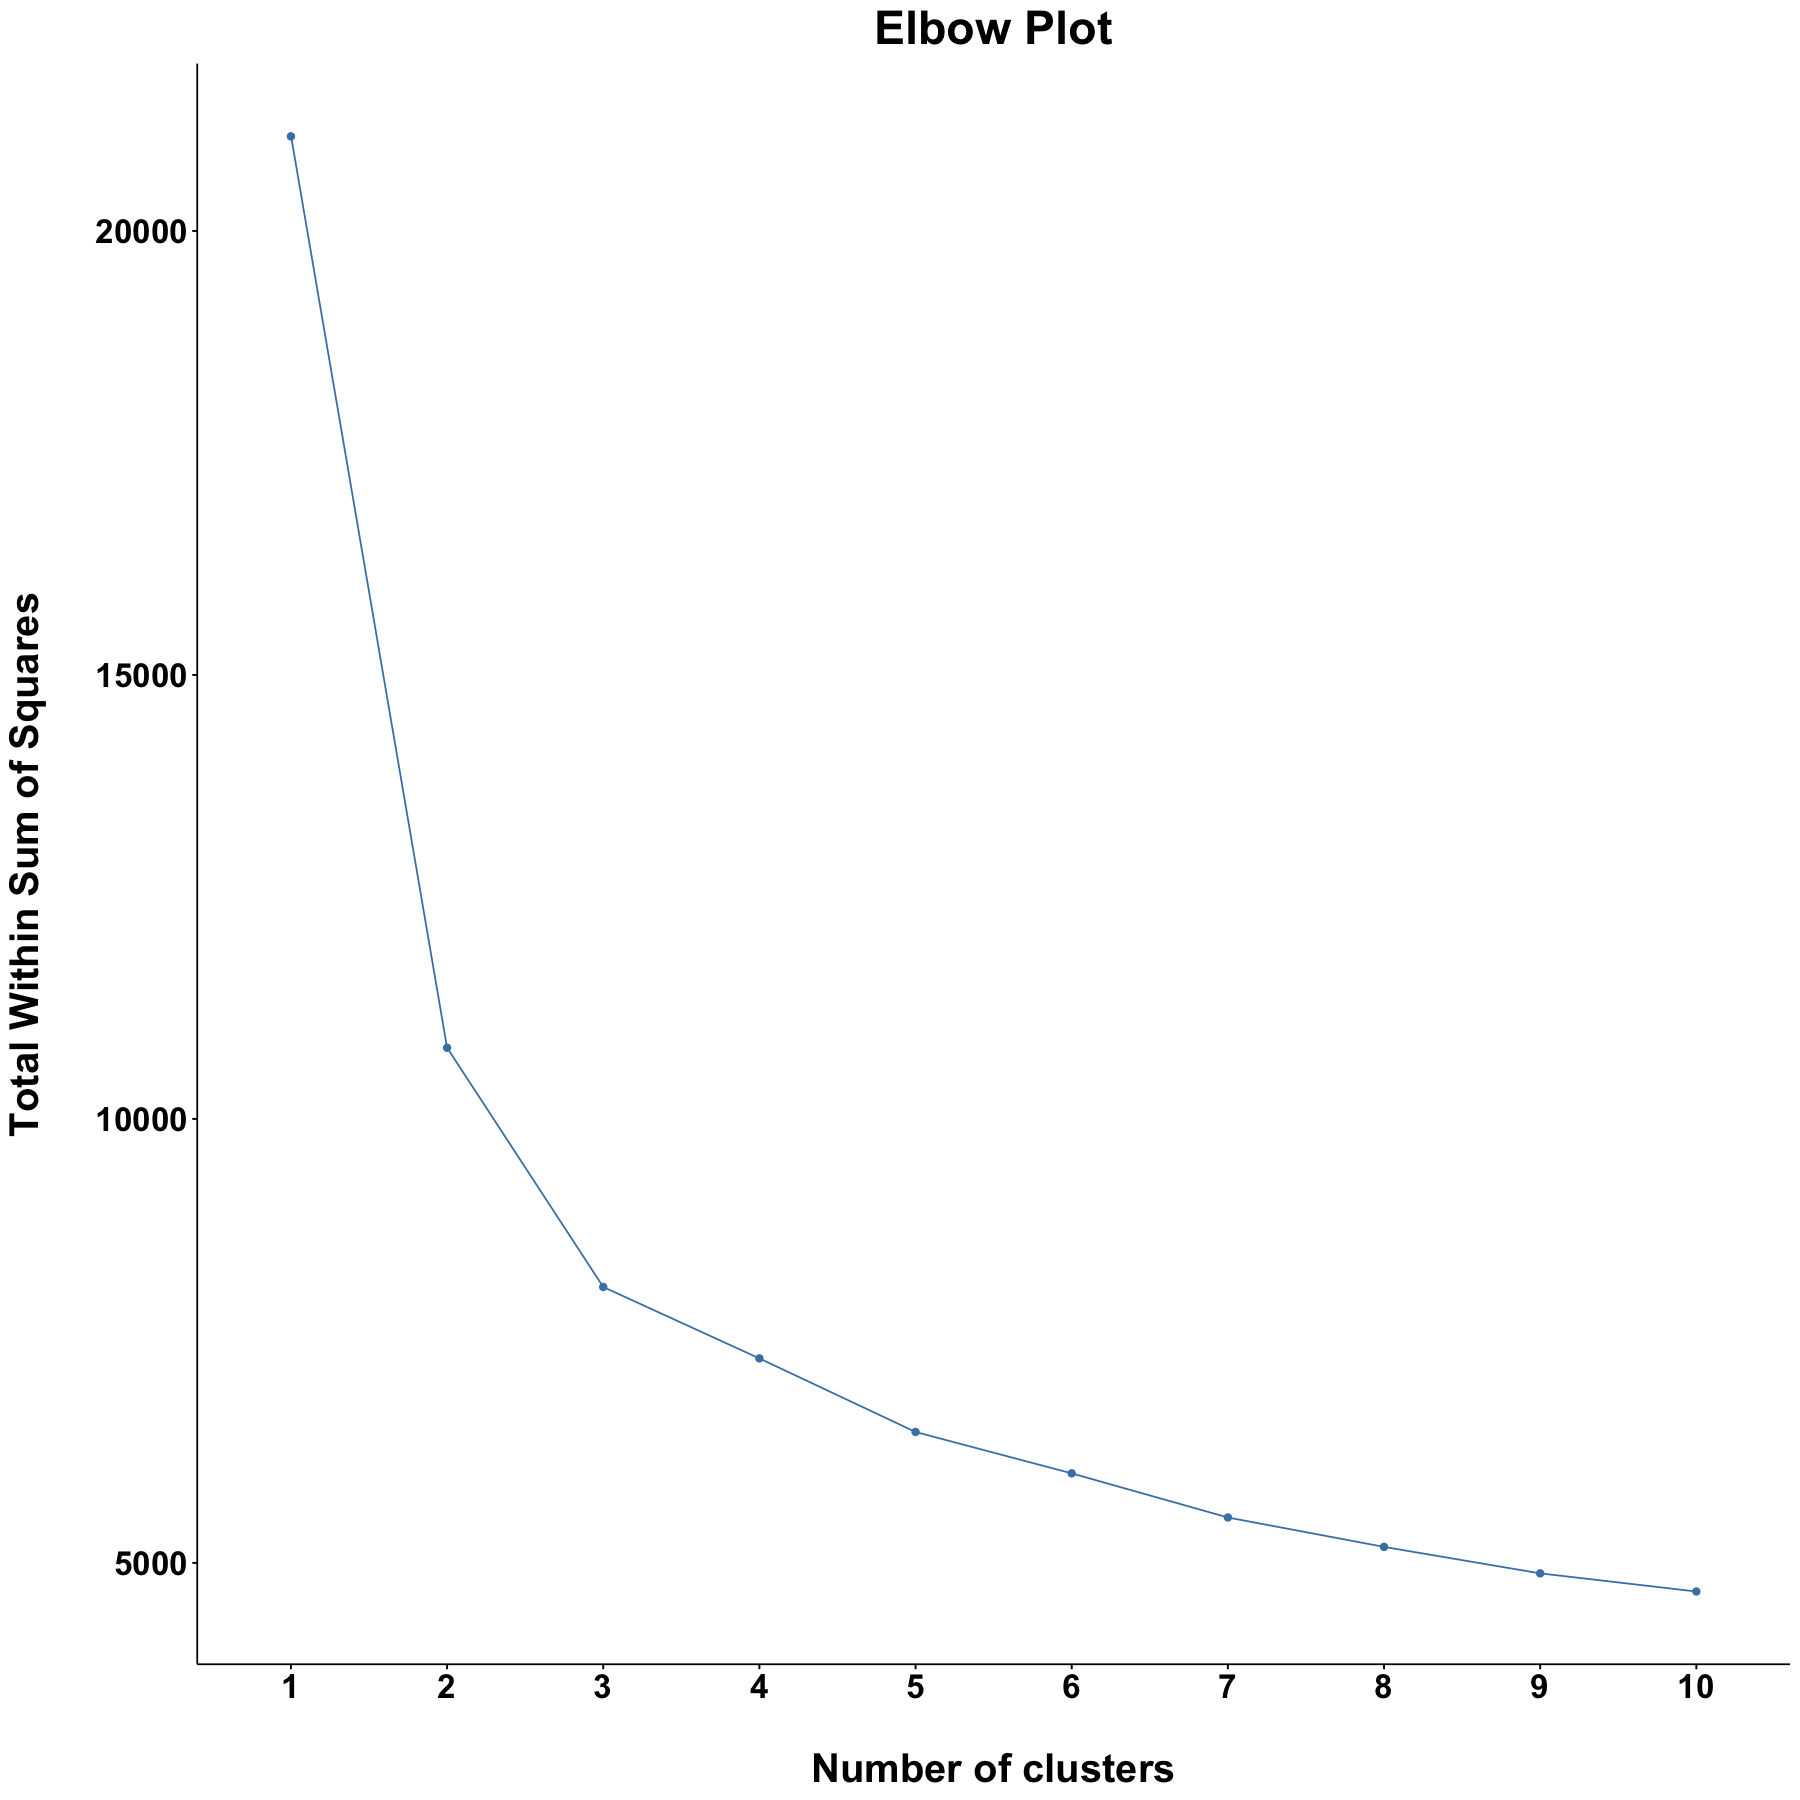

In [255]:
pca_filter <- pca$x[ ,1:4]

fviz_nbclust(pca_filter, kmeans, method='wss') +
    labs(title='Elbow Plot', x='\nNumber of clusters', y='Total Within Sum of Squares\n') +
    theme(axis.title.x=element_text(size=24, face='bold'),
          text=element_text(size=20, face='bold'),
          axis.title.y=element_text(size=24, face='bold'),
          plot.title=element_text(hjust=0.5, face='bold', size=28))

pca_kmeans <- kmeans(pca_filter, center=3, nstart=25)

## Interpretation and graphing of results
Three distinctive groups of customers with specific characteristics were specified. The lengths of variable-vectors indicate how well they are represented by the graph. In this case, nearly all vectors have equal and substantial lengths, indicating quite good representation of higher-dimensional data in 2D plot with the use of first two PCs.


Description of three general customer groups:

Group 1 (~50% of customers): Younger customers with least income and least frequent purchases, but most frequently visiting online store

Group 2 (~25% of customers): Adults with most income, buying the most products - from both physical stores and online, however more frequently from physical stores

Group 3 (~25% of customers): Adults who mostly purchase through website and visit it quite frequently, usually awaiting for discounts

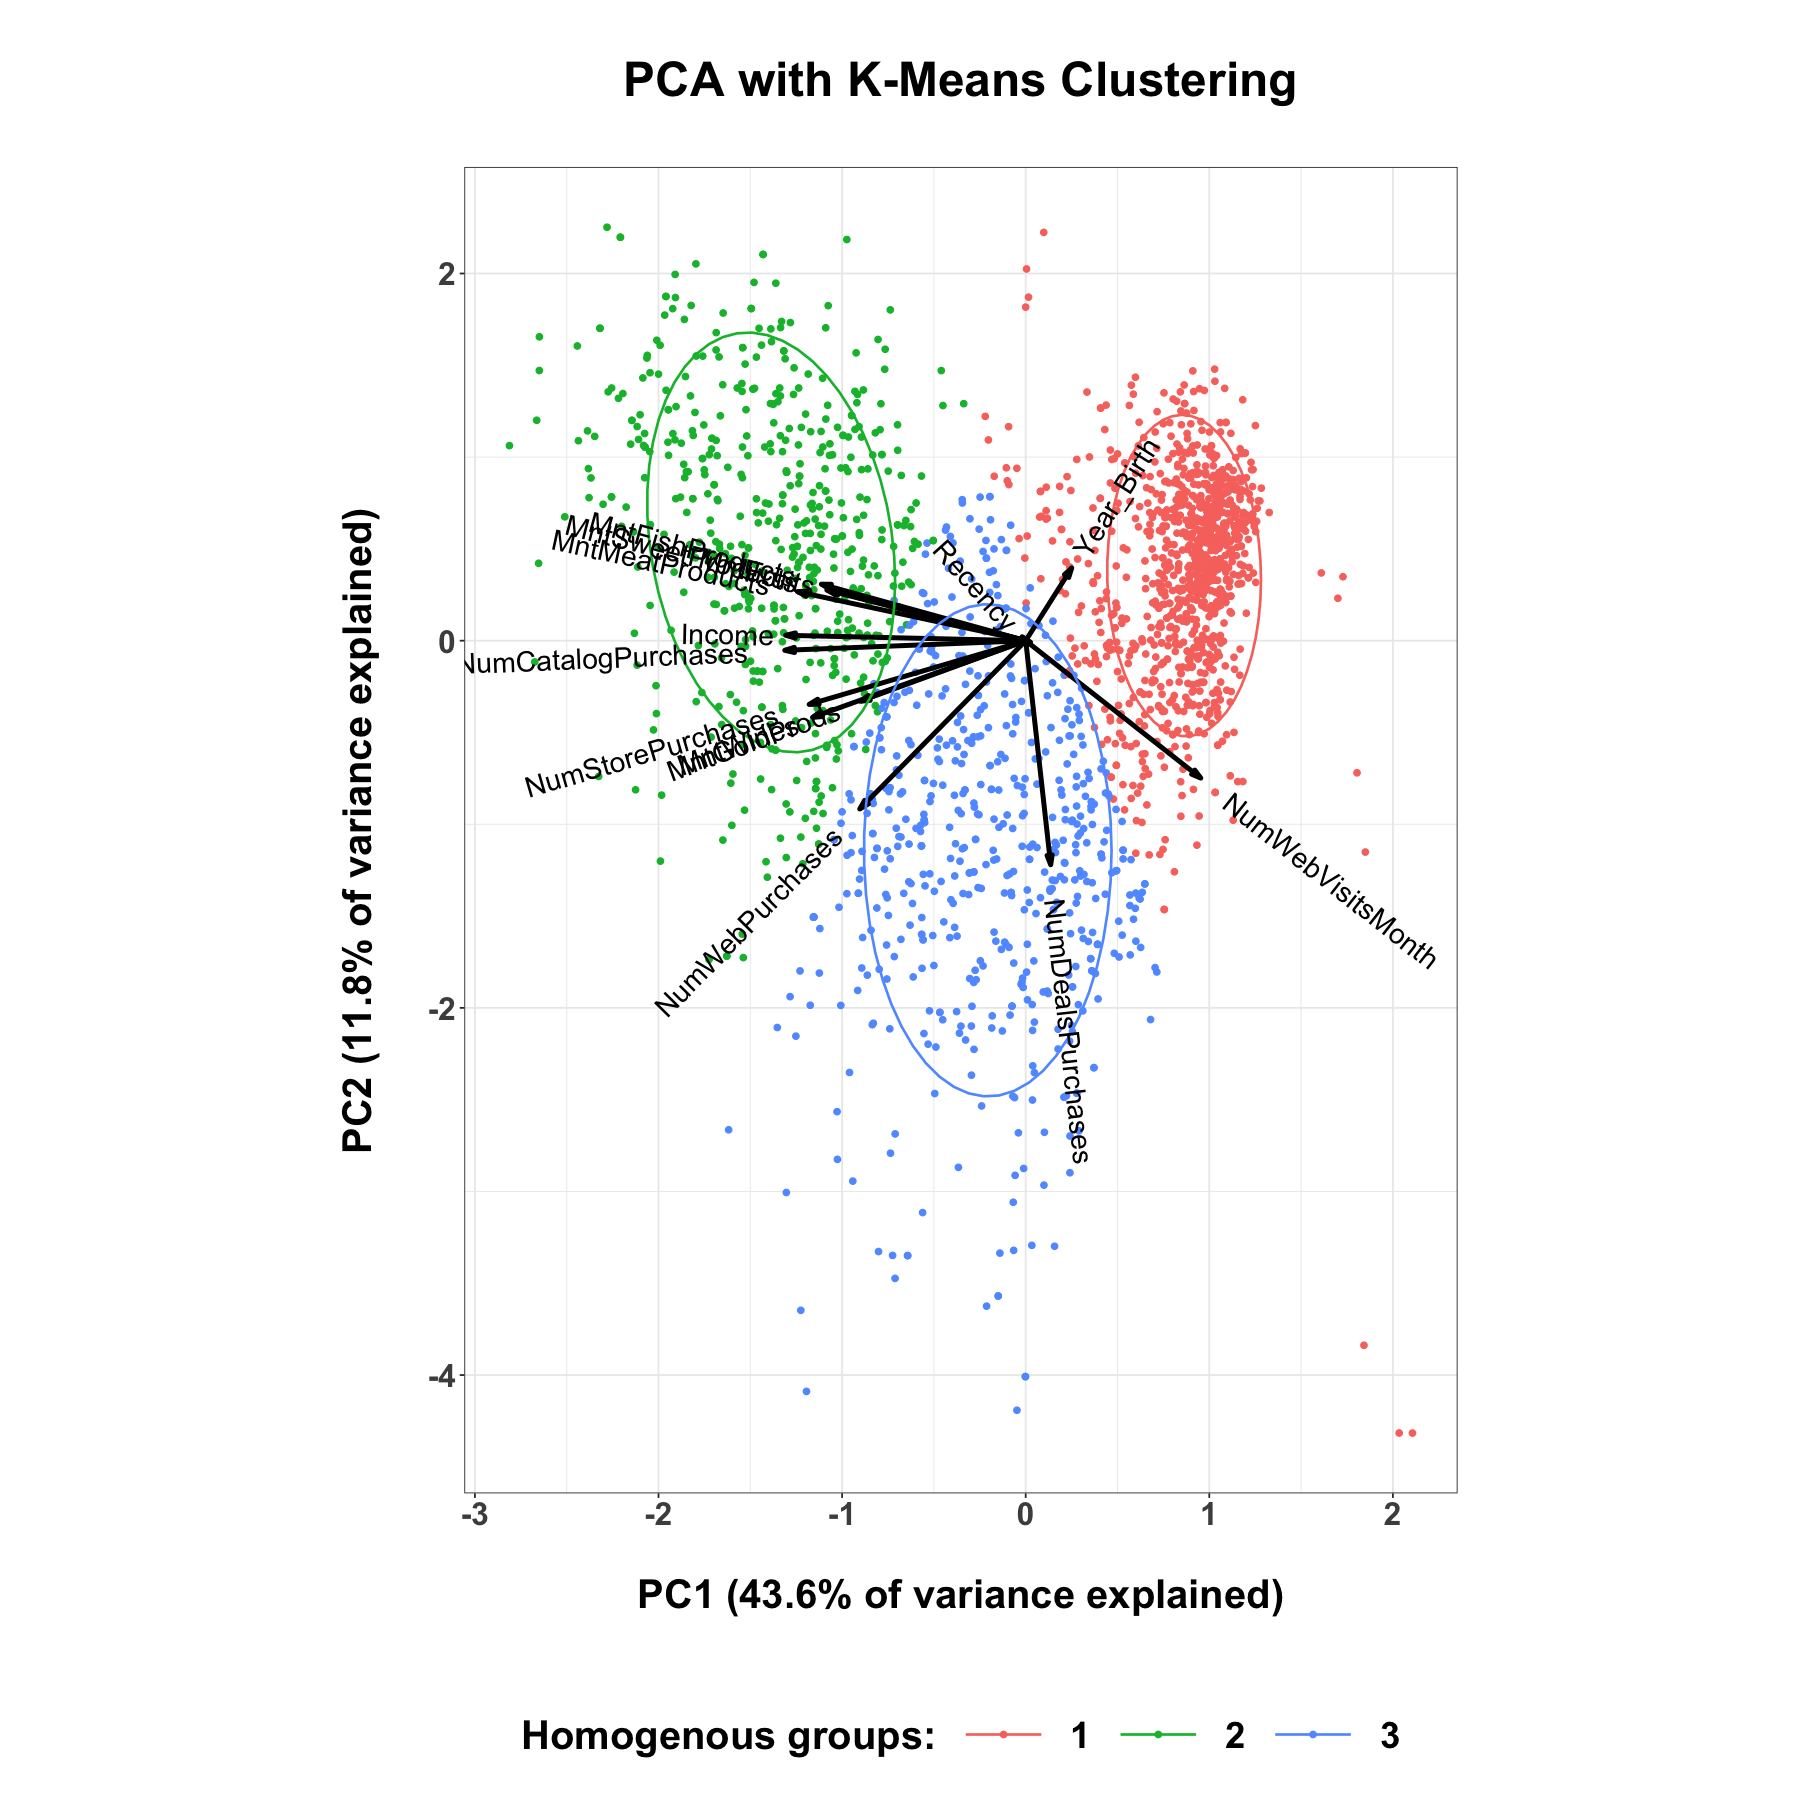

In [261]:
ggbiplot(pca,
         groups=factor(pca_kmeans$cluster),
         ellipse=T,
         ellipse.fill=F,
         ellipse.linewidth = 0.75,varname.size=6) +
    labs(x='\nPC1 (43.6% of variance explained)\n',
         y='PC2 (11.8% of variance explained)\n',
         col='Homogenous groups:', title='\nPCA with K-Means Clustering\n') +
    theme_bw() +
    theme(axis.title.x=element_text(size=24, face='bold'),
          text=element_text(size=24, face='bold'),
          axis.title.y=element_text(size=24, face='bold'),
          legend.position='bottom',
          legend.text=element_text(size=22, face='bold'),
          legend.key.size=unit(2, 'cm'),
          plot.title=element_text(hjust=0.5))

cat(
'\nDescription of three general customer groups:\n
Group 1 (~50% of customers): Younger customers with least income and least frequent purchases, but most frequently visiting online store\n
Group 2 (~25% of customers): Adults with most income, buying the most products - from both physical stores and online, however more frequently from physical stores\n
Group 3 (~25% of customers): Adults who mostly purchase through website and visit it quite frequently, usually awaiting for discounts'
)